+ Loading a PDF, splitting it, and searching it using local memory (FAISS).

In [29]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS


In [30]:
# Ingestion (Load & Split)
loader = PyPDFLoader("./files/syllabus.pdf")
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 40
)

chuncks = splitter.split_documents(docs)
len(chuncks)


81

In [31]:
# Embedding
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [32]:
# Vector Store
vector_store = FAISS.from_documents(chuncks,embeddings)

In [33]:
# Retrival
query = "What is LLM2?"
results = vector_store.similarity_search(query)

print(results[0].page_content)

LangChain
Leveraging Vector Databases in RAG Using Vector Databases for Efficient
Retrieval in RAG, Popular Vector
Databases for RAG (e.g., Pinecone,
FAISS, Chroma DB)
Role of LLMs in RAG How LLMs (Large Language Models)
Enhance Generation in RAG, Fine-
Tuning LLMs for Retrieval-Augmented
Tasks
Ultimate Data Science & GenAI Bootcamp       Page  32
Module 19


+ Moving from RAM (FAISS) to a real server (Pinecone), managing IDs, and namespaces.

In [34]:
import os
from dotenv import load_dotenv
load_dotenv()

from uuid import uuid4
import time

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

In [35]:
# load and split
loader = PyPDFLoader("./files/syllabus.pdf")
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(
    chunk_size = 800,
    chunk_overlap = 40
)

chuncks = splitter.split_documents(docs)

In [36]:
# Cloud infra setup
pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'))

index_name = "course-rag-index"

existing_indexes = pc.list_indexes().names()
if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=384, #number should must match model dimension
        metric='cosine',
        spec=ServerlessSpec(cloud="aws",region="us-east-1")
    )
    time.sleep(20)

In [37]:
# embedding
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# here is the number that should match with dimension in cloud setup
len(embedding.embed_query("Hello AI"))

# vectore store
vectore_store = PineconeVectorStore(index_name=index_name,embedding=embedding)


In [38]:
# uuid
uuids = [str(uuid4()) for _ in range(len(chuncks))]
vector_store.add_documents(documents=chuncks,ids=uuids)

['1a2dcc05-a835-4856-bd85-ad31278dfc6a',
 'e42316a0-4bb4-41c2-a782-55380d94cc3d',
 '065fba44-bc21-43e2-a14d-88a81d90fac4',
 '22da4bdd-11ae-4ea7-9014-922e47c7768f',
 '63375db0-6e82-4535-a494-0c8fe29fc65e',
 '55195fd7-d966-4d00-af8d-06944ec2de0d',
 '69e6157c-e15d-45f8-ae99-3dfe3f6f7186',
 '047c107d-a317-4b6f-9bb4-2e96943d5f77',
 'e864c284-290f-4f72-bbf3-300868918a05',
 '2f1ec9d4-939a-4811-a457-7b476a8786fe',
 '060ce910-8dc2-41d7-9a88-e9522b6a94e2',
 '61020ab8-4358-475e-a439-4a934aa1b76e',
 '6435b495-602a-4240-a930-c1f28693cfde',
 'f14b7d87-0f4f-4559-b71b-3e23f378e7eb',
 'a8ae0b2c-5f0b-4930-96f1-c327325984e5',
 '920cbfe9-2ee4-4a84-892c-5a0e4a870534',
 'a08675a9-20ef-4d43-9a79-9a8e2e6a7427',
 '706c2c52-5787-4d3a-b732-5e15b5febbbc',
 'ebcdd21e-3de5-420c-bf08-2f391e74d78d',
 'f64b37d9-2684-471d-8109-e25a8364815a',
 '7fac069b-b235-40a2-9ecd-76488a3eb9f0',
 'b8047e34-ea01-4bb5-82d4-06bfcd05fb78',
 'be08d615-0abf-41e2-a367-cc953f0e87c1',
 '111c3813-79a8-4833-9622-05c72d9f2e6a',
 'ce478038-d733-

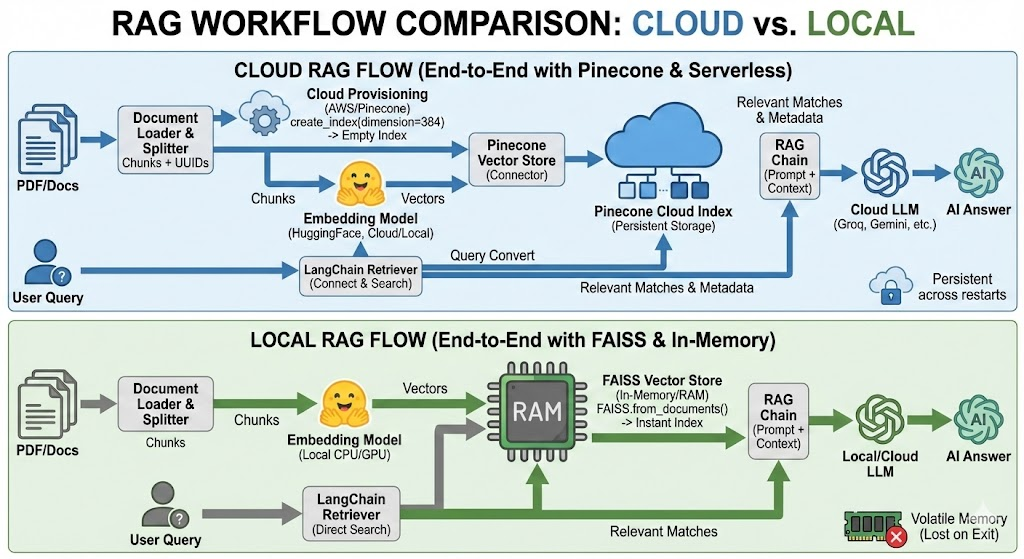

+ Connecting the LLM, using LCEL Pipes (|), and Metadata Filtering.

In [39]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pinecone import Pinecone, ServerlessSpec
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [40]:
# 1. Connect to Existing Database
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_store = PineconeVectorStore(index_name="course-rag-index", embedding=embedding)


In [41]:
# 2. Create the Retriever (The "Search Engine")
retriver = vector_store.as_retriever(search_kwargs = {"k":3})

In [48]:
# 3. Setup the LLM (The "Writer")
llm = ChatGroq(model="llama-3.1-8b-instant")

In [49]:
# 4. Define the Prompt
template = """
You are a helpful AI assistant. Answer the question based ONLY on the context provided.
Context:{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [50]:
#5. Build the Chain (The "Pipeline")
def format_doc(docs):
    return "\n\n".join([d.page_content for d in docs])

rag_chain=(
    {"context": retriver|format_doc,"question": RunnablePassthrough()}
    |prompt
    |llm
    |StrOutputParser()
)



In [51]:
# 6. Execute
query = "How is Llama 2 safer than previous models?"
print(f"\n Asking: {query}")

response = rag_chain.invoke(query)
print(f"\n Answer:\n{response}")


 Asking: How is Llama 2 safer than previous models?

 Answer:
I was created at Meta with a set of guidelines and policies that prioritize people's safety and well-being. I'm designed to be more accurate and helpful, with a focus on providing information and answers that are trustworthy and reliable.
